In [ ]:
import numpy as np
import os
import argparse

import math
import json
import numpy as np 
import scipy
import matplotlib.pylab as plt

import copy
import random

from random import randrange
from scipy.optimize import minimize 

def init_vector(dim, norm):
    vec = 2 * np.random.rand(dim) - 1.
    return vec * norm / math.sqrt(dim)

def init_arms(dim, norm, num):
    decision = np.random.rand(num, dim)
    for i in range(num):
        decision[i] = init_vector(dim, norm)
    return decision

def func(x):
    return np.exp(x)

dim = 10
sigma= 1
corruption = 50
T= 1000
repeat = 5
repeat_time= repeat
actions = 20
norm = 1
bmu = np.ones(dim)/ math.sqrt(dim)
print(bmu)



[0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
 0.31622777 0.31622777 0.31622777 0.31622777]


In [3]:
from scipy.stats import t as t_dist
def reward_function(chosen_arm, theta_star, flag,df=3, scale=1):
    expected_payoff = func(chosen_arm.dot(theta_star))

    noise = t_dist.rvs(df=df) * scale 
    
    if flag==0:
        observed_payoffs = expected_payoff + noise
    else:
        observed_payoffs = -expected_payoff + noise
    return observed_payoffs
    

In [4]:

from scipy.integrate import quad  
  
def z_s(u, y_s, sigma_s, f):  
    return (y_s - f(u)) / sigma_s  

# Define the loss function.
def objective_function(theta, lambda_k, B, k, t, phi_s, y_s, sigma_s, tau_s, f):  
   
    loss = lambda_k * k / 2 * np.linalg.norm(theta)**2  
    
    
    for s in range(1, t+1 ):  
        
        integral_func = lambda u: (tau_s[s] * z_s(u, y_s[s], sigma_s[s], f)) / np.sqrt(tau_s[s]**2 + z_s(u, y_s[s], sigma_s[s], f)**2)  
        integral_result, _ = quad(integral_func, 0, np.dot(phi_s[s], theta))  
        loss += -1 / sigma_s[s] * integral_result  
        
    return loss 


# Define the gradient of the loss function.
def gradient_function(theta, lambda_k, B, k, t, phi_s, y_s, sigma_s, tau_s, f):  
    grad = lambda_k * k * theta  
    for s in range(1, t + 1):  
        z_s_at_upper_limit = z_s(np.dot(phi_s[s], theta), y_s[s], sigma_s[s], f)  
        grad_term = (tau_s[s] * z_s_at_upper_limit) / np.sqrt(tau_s[s]**2 + z_s_at_upper_limit**2)  
        grad_integral_part = -1 / sigma_s[s] * phi_s[s] * grad_term
        grad = grad + grad_integral_part  
    return grad  
     
def constraint12(theta):
     return 1 - np.linalg.norm(theta)

def project_to_unit_ball(theta):  

    norm = np.linalg.norm(theta)  
    if norm > 1:  
        return theta / norm  
    else:  
        return theta  

In [ ]:

for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 1
    decision_t = init_arms(dim, norm, actions)
    
    B=1
    L=1
    K=1/4
    k=1/6
    delta=0.001
    lambda_= 0.1
    #lambda_= dim/B**2
    H = np.eye(dim) * lambda_
    theta = np.zeros(dim)
    beta = np.sqrt(lambda_)   
    #m_0 = 1 / (6 * np.sqrt(3 * np.log(2 * T**2 / delta)))
    m_0=1
    m_1 = 1 / (42 * np.log(2 * T**2 / delta))
    
    sigma_min = 1 / np.sqrt(T)
    print(sigma_min)
    kappa = dim *np.log(1 + (T ) / (dim * lambda_ * sigma_min ** 2))
    print(kappa)
    #tau_0 = max(np.sqrt(2 * kappa), 2 * np.sqrt(dim)) / np.sqrt(np.log(2 * T**2 / delta))
    tau_0=1
    print(tau_0,m_0,m_1)
    # Parameters for calculations
    alpha = max(np.sqrt(K) / (m_1 ** 0.25 * dim ** 0.25),corruption ** 0.5 *kappa ** (-0.25))
    print(alpha)
    sigma_ = [None] * (T + 1)
    w_ = [None] * (T + 1)
    tau_ = [None] * (T + 1)
    y_ = [None] * (T + 1) 
    var_=[None] * (T + 1)
    phi_ = [None] * (T + 1)  
    
   
    REGRET = 0
    TOTALREGRET = []
    for t in range(1,T+1):
        noise=np.random.randn(actions) *sigma 
        
        # Add corruption.
        flag = 0
        if cur_crr < corruption:
            flag = 1

        decision = init_arms(dim, norm, actions)
        
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        
        

        
        # Find the best arm.
        max_dot_product = float('-inf')  
        best_i= None 
        for i in range(actions):
            
            # Build the confidence set.
            def objective(theta_):  
                return -np.dot(decision[i], theta_)  

            def constraint1(theta_):  
                return B - np.linalg.norm(theta_)  

            def constraint2(theta_):  
                return beta - np.sqrt(np.dot(np.dot(theta_ - theta, H), theta_ - theta))  
            
            theta0 = np.zeros_like(theta)  

            con1 = {'type': 'ineq', 'fun': constraint1}  
            con2 = {'type': 'ineq', 'fun': constraint2}  
            cons = [con1, con2]  

 
            result = minimize(objective, theta0, constraints=cons)  

            optimal_theta = result.x  
            optimal_value = -result.fun  
            if optimal_value > max_dot_product:  
                max_dot_product = optimal_value 
                best_i = i
        
        
        phi_[t]= decision[best_i]
       
        
        
        
        REGRET += func(optimal_reward) -func(np.dot(phi_[t], bmu))
        
        phi_t_H_inv_norm= np.sqrt(np.dot(np.dot(phi_[t], np.linalg.inv(H)),phi_[t]))
        

        y_[t] = reward_function(phi_[t], bmu, flag)
        

        var_[t] = sigma
        sigma_[t] = max(var_[t], sigma_min, phi_t_H_inv_norm / m_0, alpha * (phi_t_H_inv_norm ** 0.5))
        w_[t]= phi_t_H_inv_norm/sigma_[t]
        tau_[t]= tau_0 * np.sqrt(1 + w_[t] ** 2) / w_[t]
        
        
        theta = minimize(fun=objective_function, x0=theta, args=(lambda_, B, k, t, phi_, y_, sigma_, tau_, func),jac=gradient_function,constraints=[{'type': 'ineq', 'fun': constraint12}]).x
        
        #if t % 100 == 0:
            #print(theta)
            #print(sigma_[t],w_[t],tau_[t],phi_[t],y_[t],var_[t],phi_t_H_inv_norm,REGRET)  


        
        # Update matrix H.
        H += np.outer(phi_[t], phi_[t]) / (sigma_[t] ** 2)
       
        #beta = (64 / k) * (2 * np.sqrt(kappa * np.log(2 * t**2 / delta)) + np.sqrt(dim * np.log(2 * t**2 / delta)) )+ 5 * np.sqrt(dim) + (4 * np.sqrt(kappa) / k)
        beta=1.
        if t %1 == 0:
            print(t)
            print(f'distance={np.linalg.norm(theta-bmu)}') 
            print(theta)
           

        
        


        TOTALREGRET.append(REGRET)
    
    
    path  = "GADA_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 
    

50 0
0.03162277660168379
138.15511557963774
1 1 0.0011117419051482273
2.0624966866464605
1
distance=1.340352104732356
[ 0.17031167  0.3972634   0.38493336 -0.32514093  0.30782649 -0.38061212
 -0.35859331 -0.17089292  0.39107845 -0.09448152]
2
distance=1.2131209868777884
[ 0.31830615  0.50278152  0.27419576 -0.14156368  0.21691069 -0.18775993
 -0.16497266 -0.33029708  0.54238331 -0.19460897]
3
distance=1.5654933834798024
[ 0.09415683  0.64252477 -0.14757688 -0.16796814 -0.1257904  -0.41518013
 -0.38491304  0.04928118  0.15103871 -0.40829965]
4
distance=1.5732314139108823
[-0.06696493  0.68052272  0.06476336 -0.01625678 -0.31360249 -0.5355711
 -0.12413795 -0.08656487 -0.00718512 -0.34613323]
5
distance=1.4897052126115635
[-0.20918876  0.68468367  0.2159421   0.13296005 -0.40718892 -0.38414164
 -0.17889624  0.03923968  0.03396982 -0.27399789]
6
distance=1.4595259718505396
[-0.27596723  0.69795845  0.29916401  0.134948   -0.22359927 -0.28283702
 -0.2276256   0.11525309 -0.08800699 -0.35517

In [6]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 0
    decision_t = init_arms(dim, norm, actions)
    
    LAMBDA = 1
    beta=1.5
    alpha=0.2
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        weight = 1
        noise= t_dist.rvs(df=3, size=actions)   * sigma
        flag = 0
        if cur_crr < corruption:
       
            flag = 1

        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMA[:,:], action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
                weight = min(1,alpha/np.sqrt(np.dot(UU,action_t)))
        REGRET += func(optimal_reward) - func(np.dot(action, bmu))
        SIGMA[:,:]  = SIGMA[:,:] + weight*np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + weight*reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
    path  = "AdditiveC_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 

50 0
50 1
50 2
50 3
50 4


In [7]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 0
    decision_t = init_arms(dim, norm, actions)
    
    LAMBDA = 1
    beta=10
    alpha=1
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        noise= t_dist.rvs(df=3, size=actions)   * sigma
        
        flag = 0
        if cur_crr < corruption:
            decision = init_arms(dim, norm, actions)
            if cur_crr < corruption:
                flag = 1
        else:
            decision = decision_t
       
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            r_action_t = np.dot(action_t, hattheta)
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += func(optimal_reward) - func(np.dot(action, bmu))
        SIGMA[:,:]  = SIGMA[:,:] + np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
    path  = "Greedy_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 

50 0
50 1
50 2
50 3
50 4


In [8]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 0
    decision_t = init_arms(dim, norm, actions)
   
    LAMBDA = 1
    beta=1
    alpha=1
    SIGMA = LAMBDA*np.diag(np.ones(dim))
    BB = np.zeros(dim)
    REGRET = 0
    TOTALREGRET = []
    for t in range(T):
        noise= t_dist.rvs(df=3, size=actions)   * sigma
       
        flag = 0
        if cur_crr < corruption:
            decision = init_arms(dim, norm, actions)
            if cur_crr < corruption:
                flag = 1
        else:
            decision = decision_t
       
        decision = init_arms(dim, norm, actions)
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        hattheta = np.linalg.lstsq(SIGMA[:,:], BB[:], rcond=-1)
        hattheta = hattheta[0]
        hattheta.shape = (dim)
        MAX_R = float("-inf")
        for a_t in range(actions):
            action_t = decision[a_t]
            UU=np.linalg.lstsq(SIGMA[:,:], action_t, rcond=-1)
            UU= UU[0]
            UU.shape = (dim)
            r_action_t = np.dot(action_t, hattheta) + beta * np.sqrt(np.dot(UU,action_t))
            if MAX_R < r_action_t: 
                MAX_R = r_action_t
                final_a_t = a_t
                action = action_t
        REGRET += func(optimal_reward) - func(np.dot(action, bmu))
        SIGMA[:,:]  = SIGMA[:,:] + np.mat(action).T * np.mat(action)
        BB[:] = BB[:] + reward[final_a_t] * action
        TOTALREGRET.append(REGRET)
    path  = "OFUL_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 
    

50 0
50 1
50 2
50 3
50 4


In [9]:
for jjjj in range(repeat):
    
    number =  jjjj-repeat_time*int(jjjj /repeat_time)
    print(corruption, number)
    cur_crr = 1
    decision_t = init_arms(dim, norm, actions)
    
    L=1
    K=1
    k=1
    delta=0.001
    lambda_= 0.1
    #lambda_= dim/B**2
    H = np.eye(dim) * lambda_
    theta = np.zeros(dim)
    beta = np.sqrt(lambda_)   
    #m_0 = 1 / (6 * np.sqrt(3 * np.log(2 * T**2 / delta)))
    m_0=1
    m_1 = 1 / (42 * np.log(2 * T**2 / delta))
    
    sigma_min = 1 / np.sqrt(T)
    print(sigma_min)
    kappa = dim *np.log(1 + (T ) / (dim * lambda_ * sigma_min ** 2))
    print(kappa)
    #tau_0 = max(np.sqrt(2 * kappa), 2 * np.sqrt(dim)) / np.sqrt(np.log(2 * T**2 / delta))
    tau_0=1
    print(tau_0,m_0,m_1)
    # Parameters for calculations.
    alpha = max(np.sqrt(K) / (m_1 ** 0.25 * dim ** 0.25),0)
    print(alpha)
    sigma_ = [None] * (T + 1)
    w_ = [None] * (T + 1)
    tau_ = [None] * (T + 1)
    y_ = [None] * (T + 1)  
    var_=[None] * (T + 1)
    phi_ = [None] * (T + 1)  
    
    
   
    REGRET = 0
    TOTALREGRET = []
    for t in range(1,T+1):
        noise=np.random.randn(actions) *sigma
        flag = 0
        if cur_crr < corruption:
            flag = 1

        decision = init_arms(dim, norm, actions)
        
        rewardS = np.random.randn(actions)
        reward = np.random.randn(actions)
        optimal_reward = float("-inf")
        for arm in range(actions):
            rewardS[arm] = noise[arm] + np.dot(decision[arm], bmu)
            reward[arm] = rewardS[arm]
            if np.dot(decision[arm], bmu) > optimal_reward:
                optimal_reward = np.dot(decision[arm], bmu)
        if flag == 1:
            cur_crr += 1
            for arm in range(actions):
                reward[arm] = noise[arm] - np.dot(decision[arm], bmu)
        
        

        
        # Find the best arm.
        max_dot_product = float('-inf')  
        best_i= None 
        for i in range(actions):
        # Construct the confidence set.
        
            def objective(theta_):  
                return -np.dot(decision[i], theta_)  
            def constraint1(theta_):  
                return B - np.linalg.norm(theta_)  

            def constraint2(theta_):  
                return beta - np.sqrt(np.dot(np.dot(theta_ - theta, H), theta_ - theta))  
            
            theta0 = np.zeros_like(theta)  

            con1 = {'type': 'ineq', 'fun': constraint1}  
            con2 = {'type': 'ineq', 'fun': constraint2}  
            cons = [con1, con2]  

 
            result = minimize(objective, theta0, constraints=cons)  

            optimal_theta = result.x  
            optimal_value = -result.fun  
            if optimal_value > max_dot_product:  
                max_dot_product = optimal_value 
                best_i = i
       
        
        phi_[t]= decision[best_i]
    
        
        
        REGRET += func(optimal_reward) -func(np.dot(phi_[t], bmu))
        
        phi_t_H_inv_norm= np.sqrt(np.dot(np.dot(phi_[t], np.linalg.inv(H)),phi_[t]))
        y_[t] = reward_function(phi_[t], bmu, flag)
        

        var_[t] = sigma
        sigma_[t] = max(var_[t], sigma_min, phi_t_H_inv_norm / m_0, alpha * (phi_t_H_inv_norm ** 0.5))
        #sigma_[t] = 1
        w_[t]= phi_t_H_inv_norm/sigma_[t]
        print(f'w_{t}={w_[t]}')
        tau_[t]= tau_0 * np.sqrt(1 + w_[t] ** 2) / w_[t]
        theta = minimize(fun=objective_function, x0=theta, args=(lambda_, B, k, t, phi_, y_, sigma_, tau_, func),jac=gradient_function,constraints=[{'type': 'ineq', 'fun': constraint12}]).x
       

        
        
        H += np.outer(phi_[t], phi_[t]) / (sigma_[t] ** 2)
       
        #beta = (64 / k) * (2 * np.sqrt(kappa * np.log(2 * t**2 / delta)) + np.sqrt(dim * np.log(2 * t**2 / delta)) )+ 5 * np.sqrt(dim) + (4 * np.sqrt(kappa) / k)
        beta=1.
        if t %10 == 0:
            print(t)
            print(np.linalg.norm(theta-bmu)) 
            print(theta)
           

        
        


        TOTALREGRET.append(REGRET)
    
    
    path  = "ADA_lowerbound_" + str(number) +"_"+ str(corruption)+".txt"
    fr = open(path,'w')
    for i in TOTALREGRET:
        fr.write(str(i))
        fr.write("\n")
    fr.close() 

50 0
0.03162277660168379
138.15511557963774
1 1 0.0011117419051482273
3.079633293041741
w_1=0.47297888447156955
w_2=0.4934686933971289
w_3=0.4967897127168505
w_4=0.5066015270491129
w_5=0.4925751482753423
w_6=0.5029874117674095
w_7=0.48040558854259685
w_8=0.5146158558729346
w_9=0.4788347545683364
w_10=0.45498072973177217
10
1.3613070797047937
[ 0.00508223 -0.19114983  0.31419622  0.13498461  0.54631047 -0.07873719
 -0.57854464  0.27189989 -0.33550675  0.1436464 ]
w_11=0.48027760263934455
w_12=0.44888508163194735
w_13=0.44185270067019417
w_14=0.45395222649809996
w_15=0.4407646211864075
w_16=0.47997463083546027
w_17=0.45221758083707503
w_18=0.459203483842131
w_19=0.4335998747859066
w_20=0.42664668327316174
20
1.6120187530193055
[-0.303727   -0.1757125  -0.09450791  0.00297417  0.14809147 -0.22588242
 -0.39791782  0.62898092 -0.48935788 -0.03941777]
w_21=0.46232240725066026
w_22=0.4308442504668582
w_23=0.4370009470983904
w_24=0.4420847206966255
w_25=0.40917360819645343
w_26=0.4238530770228

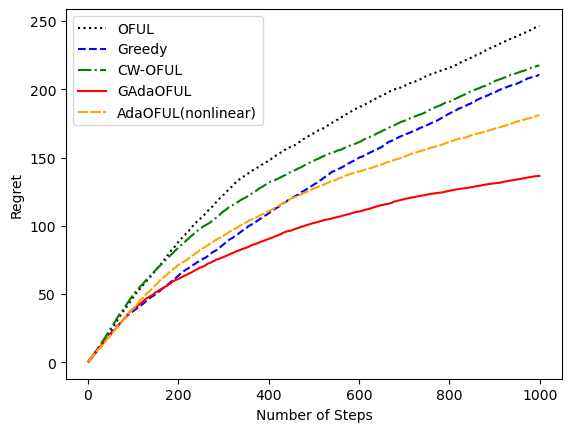

In [ ]:
number = 50
repeat = 5


rewardrobust = np.zeros(T+1)
rewardgreedy = np.zeros(T+1)
rewardOFUL = np.zeros(T+1)
rewardgada=np.zeros(T+1)
rewardADA=np.zeros(T+1)
rewardADAD=np.zeros(T+1)
finalrewardrobust = np.zeros(11)
finalrewardgreedy = np.zeros(11)
finalrewardOFUL = np.zeros(11)
for jjjj in range(repeat):
    line1=0
    path  = "AdditiveC_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardrobust[line1]=rewardrobust[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardrobust[i] = rewardrobust[i]/repeat



for jjjj in range(repeat):
    line1=0
    path  = "Greedy_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardgreedy[line1]=rewardgreedy[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardgreedy[i] = rewardgreedy[i]/repeat

for jjjj in range(repeat):
    line1=0
    path  = "GADA_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardgada[line1]=rewardgada[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardgada[i] = rewardgada[i]/repeat

for jjjj in range(repeat):
    line1=0
    path  = "OFUL_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardOFUL[line1]=rewardOFUL[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardOFUL[i] = rewardOFUL[i]/repeat


for jjjj in range(repeat):
    line1=0
    path  = "ADA_lowerbound_" + str(jjjj) +"_"+ str(number)+".txt"
    fr = open(path,'r')
    for line in fr:
        rewardADA[line1]=rewardADA[line1]+float(line)
        line1+=1
    fr.close() 
for i in range(T):
    rewardADA[i] = rewardADA[i]/repeat
    


x=list(range(1, T))

x=list(range(1,T))
plt.plot(x, rewardOFUL[0:T-1],color='black', label='OFUL',linestyle=":")
    
x=list(range(1, T))
plt.plot(x, rewardgreedy[0:T-1],color='blue', label='Greedy',linestyle= "--")

x=list(range(1, T))
plt.plot(x, rewardrobust[0:T-1],color='green', label='CW-OFUL',linestyle= "-.")
x=list(range(1, T))
plt.plot(x, rewardgada[0:T-1],color='red', label='GAdaOFUL',linestyle= "-")
x=list(range(1, T))
plt.plot(x, rewardADA[0:T-1],color='orange', label='AdaOFUL(nonlinear)',linestyle= (0, (5, 1)))

plt.legend(fontsize=10)
plt.xlabel('Number of Steps',size=10)
plt.ylabel('Regret',size=10)

plt.savefig('cor+nonlin1.pdf', dpi=300)
plt.show()
